In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_6k_collection,
                          load_isoform_and_paralog_y2h_data,
                          load_valid_isoform_clones)

In [2]:
m1h = load_m1h_activation_data()
tfs = load_annotated_6k_collection()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)

# TODO move to data_loading.py
df = pd.read_csv("../output/TF-iso_ref-vs-alt.tsv", sep="\t")
df['ref_iso'] = df['clone_acc_ref'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['alt_iso'] = df['clone_acc_alt'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
df['f_disorder_difference'] = df.apply(lambda x: tfs[x['gene_symbol']].disordered_fraction_of_different_regions(x['ref_iso'], x['alt_iso']), axis=1)


def disorder_changes_category(f):
    if pd.isnull(f):
        return np.nan
    elif f == 0:
        return 'fully ordered'
    elif f == 1:
        return 'fully disordered'
    elif f > 0 and f < 1:
        return 'partially disordered'
    else:
        raise ValueError('Invalid fraction')


df['f_disorder_difference_cat'] = df['f_disorder_difference'].apply(disorder_changes_category)
m1h['gte_2_fold'] = (m1h['mean'].abs() >= 1)
df['m1h_gte_2_fold_at_least_one_iso_per_gene'] = df['gene_symbol'].map(m1h.groupby('gene')
                                                                    ['gte_2_fold']
                                                                    .any())
df['abs_activation_fold_change_log2'] = df['activation_fold_change_log2'].abs()

dom = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])
dom = dom.loc[dom['category'] == 'effector_domain', :]

# add activation or repression
info = pd.read_excel('../data/external/Soto-et-al_MolCell_2022_Supplementary-tables.xlsx',
                     sheet_name="Table S2")
if info['Effector domain ID'].duplicated().any():
    raise UserWarning('unexpected duplicates')
info = info.set_index('Effector domain ID')
dom['type'] = dom['accession'].map(info['Domain type'])


def fraction_of_effector_domains_removed(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds[['deletion', 'frameshift']].sum().sum() / ds['length'].sum()


def insertion_in_effector_domains(row, effector_type):
    ds = dom.loc[(dom['alt_iso'] == row['alt_iso']) 
                  & (dom['type'] == effector_type), :]
    if ds.shape[0] == 0:
        return np.nan
    return ds['insertion'].sum()


for effector_type in ['AD', 'RD', 'Bif']:
    df['fraction_of_{}_domains_removed'.format(effector_type)] = df.apply(fraction_of_effector_domains_removed, effector_type=effector_type, axis=1)
    df['insertion_in_{}_domains'.format(effector_type)] = df.apply(insertion_in_effector_domains, effector_type=effector_type, axis=1)

reading from cache


In [3]:
print('Effector domain types:')
dom['type'].value_counts()

Effector domain types:


AD     587
RD     350
Bif     10
Name: type, dtype: int64

In [4]:
print('Number of different types of effector domains per gene')
dom.groupby('gene')['type'].nunique().value_counts()

Number of different types of effector domains per gene


1    105
2     32
Name: type, dtype: int64

In [5]:
(df.loc[df['activation_fold_change_log2'].notnull(),
        ['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed']]
    .notnull()
    .groupby(['fraction_of_AD_domains_removed', 'fraction_of_RD_domains_removed', 'fraction_of_Bif_domains_removed'])
    .size())

fraction_of_AD_domains_removed  fraction_of_RD_domains_removed  fraction_of_Bif_domains_removed
False                           False                           False                              175
                                                                True                                 2
                                True                            False                               38
                                                                True                                 1
True                            False                           False                               66
                                                                True                                 3
                                True                            False                               42
dtype: int64

In [6]:
# color map
t = df.loc[:,'f_disorder_difference'].values
norm = plt.Normalize(df.loc[:,'f_disorder_difference'].min(), df.loc[:,'f_disorder_difference'].max())
cmap = sns.color_palette("flare", as_cmap=True)
palette = {value: cmap(norm(value)) for value in t}

def re_color(row, palette):
    if pd.isnull(row['f_disorder_difference']):
        color = palette[0]
    else:
        color = palette[row['f_disorder_difference']]
    return color

df["color"] = df.apply(re_color, axis=1, palette=palette)
df.sample(5)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2,fraction_of_AD_domains_removed,insertion_in_AD_domains,fraction_of_RD_domains_removed,insertion_in_RD_domains,fraction_of_Bif_domains_removed,insertion_in_Bif_domains,color
291,SMAD3,ENSG00000166949,SMAD,True,SMAD3|1/4|06A07,SMAD3|2/4|06G07,ENST00000327367,NaN,False,True,...,partially disordered,True,0.246502,0.000000,0.0,NaN,NaN,NaN,NaN,"(0.63329016, 0.21816454, 0.43555493, 1.0)"
320,ZNF23,ENSG00000167377,C2H2 ZF,False,ZNF23|2/3|12F07,ZNF23|3/3|06C03,ENST00000357254|ENST00000393539|ENST00000428724,ENST00000497160,False,False,...,partially disordered,True,1.450238,NaN,NaN,NaN,NaN,NaN,NaN,"(0.89995995, 0.45494253, 0.37420106, 1.0)"
204,MXI1,ENSG00000119950,bHLH,True,MXI1|2/4|01D05,MXI1|4/4|02D05,ENST00000239007,ENST00000361248|ENST00000652604,False,False,...,partially disordered,True,2.675456,NaN,NaN,1.0,0.0,NaN,NaN,"(0.89995995, 0.45494253, 0.37420106, 1.0)"
319,ZNF23,ENSG00000167377,C2H2 ZF,False,ZNF23|2/3|12F07,ZNF23|1/3|06F04,ENST00000357254|ENST00000393539|ENST00000428724,NaN,False,True,...,fully disordered,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.29408557, 0.13721193, 0.38442775, 1.0)"
380,NFIC,ENSG00000141905,SMAD,True,NFIC|1/5|09E08,NFIC|3/5|01C05,ENST00000443272,ENST00000590282,False,False,...,fully disordered,True,1.142902,0.301418,0.0,NaN,NaN,NaN,NaN,"(0.29408557, 0.13721193, 0.38442775, 1.0)"


In [7]:
len(df)

447

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 26.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: -0.3615497684072446, -1.099521718454925


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 39.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


found: 0.0, -4.185867921507783
found: 0.4, -1.3738165060156273


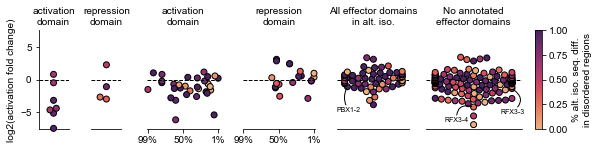

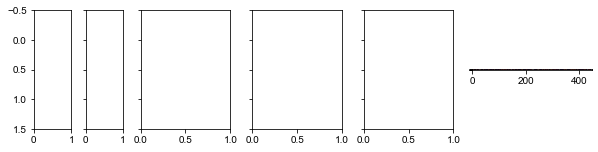

In [77]:
# seperately for repression and activation?
# full loss of activation domain
# full loss of repression domain
# partial loss of each
# loss of both?

from matplotlib import pyplot as plt


df = df.loc[df['activation_fold_change_log2'].notnull() & df['m1h_gte_2_fold_at_least_one_iso_per_gene'], :]

gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])

fig, axs = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig.set_size_inches(w=8.2, h=2)

point_size = 6


tot_loss_activ = df.loc[(df['fraction_of_AD_domains_removed'] == 1) 
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                        & (df['fraction_of_Bif_domains_removed'].isnull() | 
                           (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[0].set_title('activation\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_activ,
              y='activation_fold_change_log2', 
              x='fraction_of_AD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[0],
              palette=palette,
              hue='f_disorder_difference',
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].get_legend().remove()

tot_loss_repr = df.loc[(df['fraction_of_RD_domains_removed'] == 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0)), :]
axs[1].set_title('repression\ndomain',
fontsize=10)
sns.swarmplot(data=tot_loss_repr,
              y='activation_fold_change_log2', 
              x='fraction_of_RD_domains_removed',
              size=point_size,
            clip_on=False,
              ax=axs[1],
              palette=palette,
              hue='f_disorder_difference',
               linewidth=1,
               edgecolor="black",
              alpha=1)
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].get_legend().remove()


# tot_loss_both = df.loc[(df['fraction_of_AD_domains_removed'] == 1) &
#                           (df['fraction_of_RD_domains_removed'] == 1), :]
# axs[2].set_title('both activ. &\nrepr. domains',
# fontsize=10)
# sns.swarmplot(data=tot_loss_both,
#               y='activation_fold_change_log2', 
#               x='fraction_of_RD_domains_removed',
#               size=point_size,
#             clip_on=False,
#               ax=axs[2],
#               palette=palette,
#               hue='f_disorder_difference',
#                linewidth=1,
#                edgecolor="black",
#               alpha=1)
# axs[2].set_xticks([])
# axs[2].set_xlabel('')
# axs[2].get_legend().remove()


# now partial loss
axs[2].set_title('activation\ndomain',
fontsize=10)
partial_loss_activ = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
              & (df['fraction_of_AD_domains_removed'] > 0) 
                & (df['fraction_of_AD_domains_removed'] < 1)
                        & (df['fraction_of_RD_domains_removed'].isnull() | 
                           (df['fraction_of_RD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]
axs[2].scatter(partial_loss_activ.loc[:, 'fraction_of_AD_domains_removed'].values,
               partial_loss_activ.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_activ.loc[:, 'color'].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[2].set_xlabel('')
axs[2].set_xlim(1, 0)
axs[2].set_xticks([0.99, 0.5, 0.01])
axs[2].set_xticklabels([f'{x:.0%}' for x in axs[2].get_xticks()])


axs[3].set_title('repression\ndomain',
fontsize=10)
partial_loss_repr = df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] 
                & (df['fraction_of_RD_domains_removed'] > 0)
                  &  (df['fraction_of_RD_domains_removed'] < 1)
                          & (df['fraction_of_AD_domains_removed'].isnull() | 
                             (df['fraction_of_AD_domains_removed'] == 0))
                          & (df['fraction_of_Bif_domains_removed'].isnull() | 
                             (df['fraction_of_Bif_domains_removed'] == 0))), :]

axs[3].scatter(partial_loss_repr.loc[:, 'fraction_of_RD_domains_removed'].values,
               partial_loss_repr.loc[:, 'activation_fold_change_log2'].values,
           alpha=1,
           s=point_size**2,
            c=partial_loss_repr.loc[:, 'color'].values,
               linewidth=1,
               edgecolor="black",
           clip_on=False)
axs[3].set_xlabel('')
axs[3].set_xlim(1, 0)
axs[3].set_xticks([0.99, 0.5, 0.01])
axs[3].set_xticklabels([f'{x:.0%}' for x in axs[3].get_xticks()])


all_retained = df.loc[((df['fraction_of_AD_domains_removed'] == 0) |
                          (df['fraction_of_RD_domains_removed'] == 0) |
                          (df['fraction_of_Bif_domains_removed'] == 0))
                          & (df['fraction_of_AD_domains_removed'].isnull() | (df['fraction_of_AD_domains_removed'] == 0)) 
                           & (df['fraction_of_RD_domains_removed'].isnull() | (df['fraction_of_RD_domains_removed'] == 0)) 
                           & (df['fraction_of_Bif_domains_removed'].isnull() | (df['fraction_of_Bif_domains_removed'] == 0)) 
                           ,
                           :]
axs[4].set_title('All effector domains\nin alt. iso.',
fontsize=10)
sns.swarmplot(data=all_retained,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[4],
              color=sns.color_palette("flare")[0],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue='f_disorder_difference',
              palette=palette)
axs[4].set_xticks([])
axs[4].set_xlabel('')
axs[4].get_legend().remove()

# annotate pbx1
pbx1_y = df.loc[(df["clone_acc_alt"] == "PBX1|2/2|02C05"), 'activation_fold_change_log2'].values[0]
for point in axs[4].collections:
    for x, y in point.get_offsets():
        if np.isclose(pbx1_y, y):
            print("found: %s, %s" % (x, y))
            axs[4].annotate("PBX1-2", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.3"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))

# missing stuff
incl = tot_loss_activ.append(tot_loss_repr).append(tot_loss_both).append(partial_loss_activ).append(partial_loss_repr).append(all_retained)
no_annot = df.loc[~df.index.isin(incl.index.values)]
axs[5].set_title('No annotated\neffector domains',
fontsize=10)
sns.swarmplot(data=no_annot,
              y='activation_fold_change_log2', 
              x='m1h_gte_2_fold_at_least_one_iso_per_gene',
              size=point_size,
            clip_on=False,
              ax=axs[5],
              color=sns.color_palette("flare")[0],
               linewidth=1,
               edgecolor="black",
              alpha=1,
              hue='f_disorder_difference',
              palette=palette)
axs[5].set_xticks([])
axs[5].set_xlabel('')
axs[5].get_legend().remove()

# annotate RFX3-3
rfx3_y = df.loc[(df["clone_acc_alt"] == "RFX3|3/5|08G08"), 'activation_fold_change_log2'].values[0]
rfx4_y = df.loc[(df["clone_acc_alt"] == "RFX3|4/5|11D09"), 'activation_fold_change_log2'].values[0]
for point in axs[5].collections:
    for x, y in point.get_offsets():
        if np.isclose(rfx3_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-3", xy=(x, y), xytext=(1, -20), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=0.7"), 
                            ha="center", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
        if np.isclose(rfx4_y, y):
            print("found: %s, %s" % (x, y))
            axs[5].annotate("RFX3-4", xy=(x, y), xytext=(-5, -10), textcoords='offset points',
                            arrowprops = dict(arrowstyle="-", connectionstyle="arc3,rad=-0.7"), 
                            ha="right", va="top", fontsize=7,
                            bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))


# add colorbar
# mirror figure
gs_kw = dict(width_ratios=[0.5, 0.5, 1.2, 1.2, 1.2, 1.6])
fig2, axs2 = plt.subplots(1, 6, sharey=True, gridspec_kw=gs_kw)
fig2.set_size_inches(w=8.2, h=2)
map1 = axs2[5].imshow(np.stack([t, t]), cmap="flare")
fig.colorbar(map1, ax=axs[5], aspect=60, label="% alt. iso. seq. diff.\nin disordered regions")


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(-7.5, 7.5)
    ax.axhline(y=0, color='black', linewidth=1, linestyle='dashed')
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.set_ylabel("")
axs[0].set_ylabel("log2(activation fold change)")
fig.savefig('../figures/activation_vs_domain_removal.pdf', bbox_inches='tight')

In [75]:
df[df["gene_symbol"] == "PBX1"][["gene_symbol", "clone_acc_ref", "clone_acc_alt", "fraction_of_AD_domains_removed",
                                 "fraction_of_RD_domains_removed", "fraction_of_Bif_domains_removed",
                                 "m1h_gte_2_fold_at_least_one_iso_per_gene",
                                 "activation_fold_change_log2"]]

,gene_symbol,clone_acc_ref,clone_acc_alt,fraction_of_AD_domains_removed,fraction_of_RD_domains_removed,fraction_of_Bif_domains_removed,m1h_gte_2_fold_at_least_one_iso_per_gene,activation_fold_change_log2
20,PBX1,PBX1|1/2|02A05,PBX1|2/2|02C05,NaN,0.0,NaN,True,-1.099522


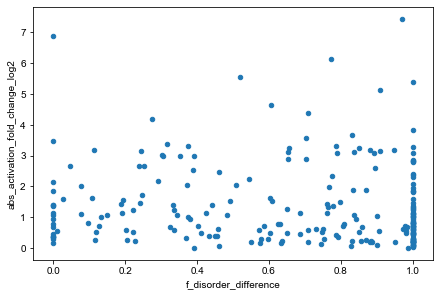

In [57]:
df.plot.scatter(x='f_disorder_difference', y='abs_activation_fold_change_log2')

In [36]:
x_var = 'f_disorder_difference'
y_var = 'activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.07470937141695498, 0.2529507103769628)
SpearmanrResult(correlation=0.1071481018046003, pvalue=0.10058356056724486)


In [37]:
x_var = 'f_disorder_difference'
y_var = 'abs_activation_fold_change_log2'
x, y = df.loc[df[x_var].notnull() & df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(-0.0837288170698881, 0.19995186764778164)
SpearmanrResult(correlation=-0.15538103718127458, pvalue=0.01690066916679032)


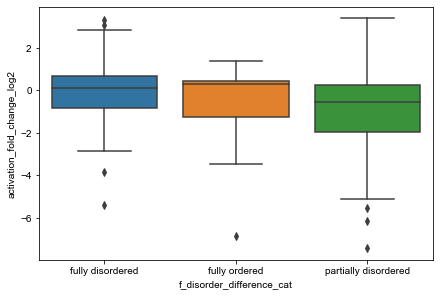

In [38]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='activation_fold_change_log2')

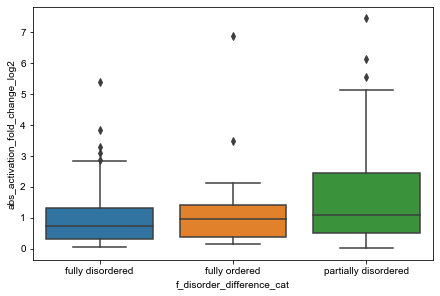

In [39]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='abs_activation_fold_change_log2')

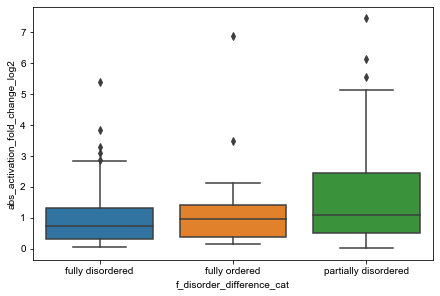

In [40]:
sns.boxplot(data=df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True), :],
            x='f_disorder_difference_cat',
            y='abs_activation_fold_change_log2')

In [41]:
stats.mannwhitneyu(
        df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully ordered'),
               'abs_activation_fold_change_log2'].values,
               df.loc[(df['m1h_gte_2_fold_at_least_one_iso_per_gene'] == True)
               & (df['f_disorder_difference_cat'] == 'fully disordered')
               , 'abs_activation_fold_change_log2'].values
                          )

MannwhitneyuResult(statistic=659.0, pvalue=0.20674808462040722)

Interestingly, I don't see a difference between disordered and ordered changes and 
activation levels. Check for confounding factors like the size of the changes.

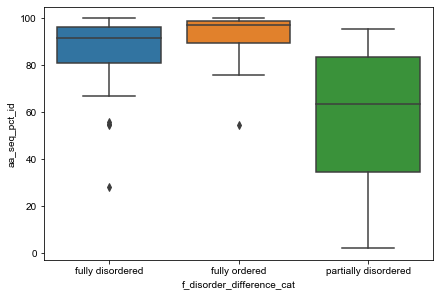

In [42]:
sns.boxplot(data=df, x='f_disorder_difference_cat', y='aa_seq_pct_id', 
            order=['fully disordered',
                   'fully ordered',
                   'partially disordered'])

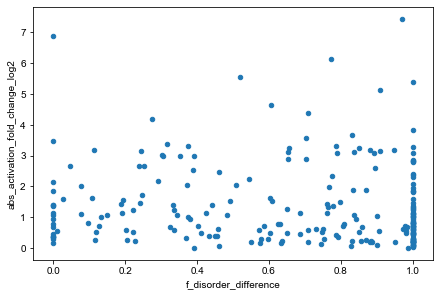

In [43]:
df.plot.scatter(x='f_disorder_difference', y='abs_activation_fold_change_log2')

In [44]:
# x axis as size of change (or aa %id), y axis as act diff, split by dis and ordered

In [45]:
# check examples
(df.loc[df['f_disorder_difference_cat'] == 'fully ordered',
         :]
         .sort_values('abs_activation_fold_change_log2',
                      ascending=False)).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,f_disorder_difference,f_disorder_difference_cat,m1h_gte_2_fold_at_least_one_iso_per_gene,abs_activation_fold_change_log2,fraction_of_AD_domains_removed,insertion_in_AD_domains,fraction_of_RD_domains_removed,insertion_in_RD_domains,fraction_of_Bif_domains_removed,insertion_in_Bif_domains
114,TBPL1,ENSG00000028839,TBP,False,TBPL1|1/2|04H06,TBPL1|2/2|04A07,ENST00000237264|ENST00000613034,ENST00000367871,False,False,...,0.0,fully ordered,True,6.864281,NaN,NaN,NaN,NaN,NaN,NaN
224,E2F8,ENSG00000129173,E2F,True,E2F8|1/4|03G03,E2F8|2/4|03A06,ENST00000250024|ENST00000527884|ENST00000620009,NaN,False,True,...,0.0,fully ordered,True,3.464671,NaN,NaN,NaN,NaN,NaN,NaN
332,MLX,ENSG00000108788,bHLH,True,MLX|1/4|11G02,MLX|2/4|01D12,ENST00000435881,NaN,False,True,...,0.0,fully ordered,True,2.129417,NaN,NaN,NaN,NaN,NaN,NaN
11,NFIA,ENSG00000162599,SMAD,True,NFIA|2/5|02G09,NFIA|3/5|02E09,ENST00000403491,ENST00000407417,False,False,...,0.0,fully ordered,True,1.845586,0.000000,0.0,0.0,0.0,NaN,NaN
260,TFCP2,ENSG00000135457,Grainyhead,True,TFCP2|1/3|03E08,TFCP2|2/3|03H07,ENST00000257915,NaN,False,True,...,0.0,fully ordered,True,1.401124,0.284916,0.0,0.0,0.0,NaN,NaN


In [46]:
df['f_disorder_difference_cat'].value_counts()

partially disordered    138
fully disordered         79
fully ordered            19
Name: f_disorder_difference_cat, dtype: int64

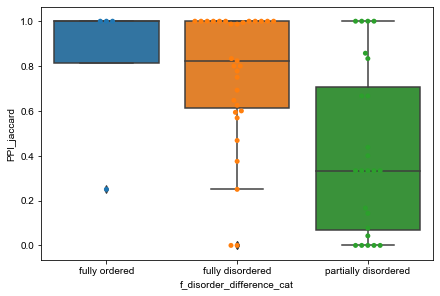

In [47]:
# TODO move PPI stuff to different notebook
sns.swarmplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')
sns.boxplot(data=df.loc[(df['n_positive_PPI_ref'] > 0) & (df['n_positive_PPI_alt'] > 0)], 
              x='f_disorder_difference_cat', y='PPI_jaccard')

In [48]:
x = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully ordered'),
       'PPI_jaccard'].values
y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
       (df['n_positive_PPI_alt'] > 0) &
       (df['f_disorder_difference_cat'] == 'fully disordered'),
       'PPI_jaccard'].values
stats.mannwhitneyu(x, y)

MannwhitneyuResult(statistic=45.0, pvalue=0.18826235330351887)

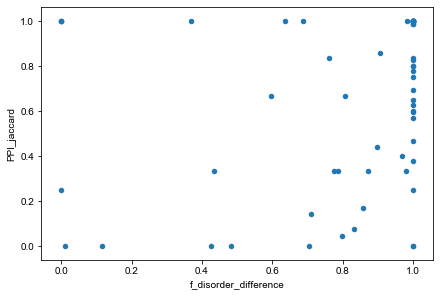

In [49]:
(df.loc[(df['n_positive_PPI_ref'] > 0) & 
        (df['n_positive_PPI_alt'] > 0), 
        :].plot.scatter(x='f_disorder_difference', y='PPI_jaccard'))

In [50]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.2167987760994965, 0.09908339031720248)
SpearmanrResult(correlation=0.2763824678991044, pvalue=0.03409237427596511)


In [51]:
x_var = 'f_disorder_difference'
y_var = 'PPI_jaccard'
x, y = df.loc[(df['n_positive_PPI_ref'] > 0) & 
              (df['n_positive_PPI_alt'] > 0) &
              (df['f_disorder_difference'] > 0) &
              (df['f_disorder_difference'] < 1) &
              df[x_var].notnull() &
              df[y_var].notnull(), [x_var, y_var]].values.T
print(stats.pearsonr(x, y))
print(stats.spearmanr(x, y))

(0.2825089068106956, 0.18104003872503516)
SpearmanrResult(correlation=0.3134951916946277, pvalue=0.13577250432041632)
